# Lab 6: Random Forest Regression on Malagasy Mammal Traits

### Introduction
 In Lab 5, we used functional trait data on bird species to predict their presence in a given climate type. This week we are using regression tree models on a similar dataset, this one on mammal species.  Our goal is to predict the total number of climate types each mammal species inhabits.

You will compare performance of a single decision tree with a tuned random forest to get a sense of the effectiveness of ensemble methods with optimized hyperparameter values.

There is a fair amount of missing data in this set, which can lead to low reliability of feature splits, increased overfitting, and decreased accuracy of tree models. You will address this issue with a combination of variable omission and imputation.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

### Step 1: Read data and retain a subset of the columns
Similar to last week, we will need to take some steps to get the data in a usable form. We again reformat the diet-related variable names to match this set: `Diet_Vertebrates`,
    `Diet_Fruits`, `Diet_Flowers`, `Diet_Seeds`, `Diet_Plants`, `Diet_Other`. Then drop columns that are not relevant functional traits or climate type variables.   Next, drop any remaining  variables that have greater than 40% of the observations missing. Print the final dataframe shape. 

In [2]:
# Read in data and rename columns
dat = pd.read_csv("data/MamTraitData.csv", encoding="ISO-8859-1", na_values=-999).rename(columns={
    'Diet: invertebrates': 'Diet_Invertebrates',
    'Diet: vertebrates': 'Diet_Vertebrates',
    'Diet: fruits': 'Diet_Fruits',
    'Diet: flower/nectar/pollen/gums': 'Diet_Flowers',
    'Diet: seeds': 'Diet_Seeds',
    'Diet: other plant materials': 'Diet_Plants',
    'Diet: scavenge; garbage; carrion; carcasses': 'Diet_Other'
})

# Print the shape of the data
print(f"Initial DataFrame Shape: {dat.shape}")

# Drop columns with more than 40% missing data
dat = dat.dropna(thresh=0.6*dat.shape[0], axis = 1)

# Print new df with dropped columns
print(f"Final DataFrame shape: {dat.shape}")

# View df
dat

Initial DataFrame Shape: (214, 24)
Final DataFrame shape: (214, 17)


,AdultBodyMass,Diet_Invertebrates,Diet_Vertebrates,Diet_Fruits,Diet_Flowers,Diet_Seeds,Diet_Plants,Diet_Other,HabitatBreadth,ActivityCycle,ForagingStratum,LitterSize,Dry,Humid,Montane,Subarid,Subhumid
0,78.00,yes,no,yes,yes,no,yes,no,1.0,2.0,3.0,1.00,0,1,1,0,1
1,1082.00,no,no,yes,no,no,yes,no,1.0,1.0,3.0,NaN,0,1,0,0,1
2,946.00,no,no,yes,no,no,yes,no,2.0,1.0,3.0,NaN,1,0,0,0,0
3,1180.00,no,no,yes,no,no,yes,no,2.0,1.0,3.0,1.01,1,1,1,0,1
4,1212.50,no,no,yes,no,no,yes,no,1.0,1.0,3.0,NaN,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,8.50,yes,no,no,no,no,no,no,2.0,1.0,4.0,NaN,1,1,1,1,1
210,3019.00,no,no,yes,no,no,yes,no,1.0,3.0,3.0,2.60,0,1,0,0,0
211,3524.00,no,no,yes,no,no,no,no,2.0,2.0,3.0,2.03,0,1,0,0,1
212,21.80,yes,yes,no,no,no,no,no,1.0,NaN,NaN,NaN,0,1,0,0,1


### Step 2: Imputation with KNN
Now impute the values of the missing data in the remaining numeric columns using k-nearest neighbors with `KNNImputer()`. Use the 5 nearest neighbors. This allows us to implement the knn algorithm to predict the missing values for an observation based on similar complete observations.Perform and print a check to ensure that there are no more NA values. 

In [3]:
# Impute missing values using KNN
knn_impute = KNNImputer(n_neighbors=5)

# Impute to only the remaining numeric columns
dat_knn_impute = knn_impute.fit_transform(dat.select_dtypes(include=['float64']))

# Convert back to a df
dat_knn_impute = pd.DataFrame(dat_knn_impute, columns = dat.select_dtypes(include=['float64']).columns)

# This impute is for only the float columns, need to incoporate back into the original df
# I am not sure exactly how to do this, but I am going to make a new categorical df and then merge the two
dat_categorical = dat.select_dtypes(exclude=['float64'])

# Concat the two 
dat = pd.concat([dat_knn_impute, dat_categorical], axis = 1)

# Check for missing values
dat.isnull().sum()


AdultBodyMass          0
HabitatBreadth         0
ActivityCycle          0
ForagingStratum        0
LitterSize             0
Diet_Invertebrates    15
Diet_Vertebrates      15
Diet_Fruits           15
Diet_Flowers          15
Diet_Seeds            15
Diet_Plants           15
Diet_Other            15
Dry                    0
Humid                  0
Montane                0
Subarid                0
Subhumid               0
dtype: int64

### Step 3: Create target variable and numerical encoding 
Create the target variable (`nClimates`) representing the  number of climates in which a species was present. Then finish preparing the data to be used in our models.

- Create a new column `nClimates` that combines the information of the five climate type variables
- Drop the original `Dry`, `Humid`, `Montane`, `Subarid`, and `Subhumid` columns
- Encode categorical variables
- Split the dataset into training and test sets. Use a random state of 808. 

In [4]:
# Create a new column nClimates combining 5 climate types
dat['nClimates'] = dat[['Dry', 'Humid', 'Montane', 'Subarid', 'Subhumid']].sum(axis=1)

# Drop the original climate columns
dat = dat.drop(columns=['Dry', 'Humid', 'Montane', 'Subarid', 'Subhumid'])

# View to check
dat


,AdultBodyMass,HabitatBreadth,ActivityCycle,ForagingStratum,LitterSize,Diet_Invertebrates,Diet_Vertebrates,Diet_Fruits,Diet_Flowers,Diet_Seeds,Diet_Plants,Diet_Other,nClimates
0,78.00,1.0,2.0,3.0,1.000,yes,no,yes,yes,no,yes,no,3
1,1082.00,1.0,1.0,3.0,1.402,no,no,yes,no,no,yes,no,2
2,946.00,2.0,1.0,3.0,4.692,no,no,yes,no,no,yes,no,1
3,1180.00,2.0,1.0,3.0,1.010,no,no,yes,no,no,yes,no,4
4,1212.50,1.0,1.0,3.0,1.540,no,no,yes,no,no,yes,no,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,8.50,2.0,1.0,4.0,1.668,yes,no,no,no,no,no,no,5
210,3019.00,1.0,3.0,3.0,2.600,no,no,yes,no,no,yes,no,1
211,3524.00,2.0,2.0,3.0,2.030,no,no,yes,no,no,no,no,2
212,21.80,1.0,1.0,2.2,2.600,yes,yes,no,no,no,no,no,2


In [5]:
# Impute the categorical variables with mode
dat = dat.fillna(dat.mode().iloc[0])

# Check for missing values
dat.isnull().sum()


AdultBodyMass         0
HabitatBreadth        0
ActivityCycle         0
ForagingStratum       0
LitterSize            0
Diet_Invertebrates    0
Diet_Vertebrates      0
Diet_Fruits           0
Diet_Flowers          0
Diet_Seeds            0
Diet_Plants           0
Diet_Other            0
nClimates             0
dtype: int64

In [6]:
# Encode the categorical variables
for col in dat.select_dtypes(include=['object']).columns:
    dat[col] = LabelEncoder().fit_transform(dat[col])

# View df
dat

,AdultBodyMass,HabitatBreadth,ActivityCycle,ForagingStratum,LitterSize,Diet_Invertebrates,Diet_Vertebrates,Diet_Fruits,Diet_Flowers,Diet_Seeds,Diet_Plants,Diet_Other,nClimates
0,78.00,1.0,2.0,3.0,1.000,1,0,1,1,0,1,0,3
1,1082.00,1.0,1.0,3.0,1.402,0,0,1,0,0,1,0,2
2,946.00,2.0,1.0,3.0,4.692,0,0,1,0,0,1,0,1
3,1180.00,2.0,1.0,3.0,1.010,0,0,1,0,0,1,0,4
4,1212.50,1.0,1.0,3.0,1.540,0,0,1,0,0,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,8.50,2.0,1.0,4.0,1.668,1,0,0,0,0,0,0,5
210,3019.00,1.0,3.0,3.0,2.600,0,0,1,0,0,1,0,1
211,3524.00,2.0,2.0,3.0,2.030,0,0,1,0,0,0,0,2
212,21.80,1.0,1.0,2.2,2.600,1,1,0,0,0,0,0,2


### Step 4: Train a decision tree
Train a single decision tree to predict the number of climate types inhabited by each species.

- Train a `DecisionTreeRegressor`.  Let's apply a constraint on its growth by not allowing the tree to grow further than 5 levels. Use a random state of 808. 
- Make predictions
- Visualize the decision tree using `plot_tree`
- Evaluate and print its performance using mse

In [7]:
# Identify the features and target variable
X = dat.drop(columns=['nClimates'])
y = dat['nClimates']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=808)

# Create classifier
dt = DecisionTreeRegressor(random_state=808, max_depth=5)

# Fit a decision tree regressor
dt.fit(X_train, y_train)

# Make predictions
y_pred = dt.predict(X_test)

# Calculate mse
mse = mean_squared_error(y_test, y_pred) 
print(f"Mean Squared Error: {mse:.3f}")

Mean Squared Error: 1.990


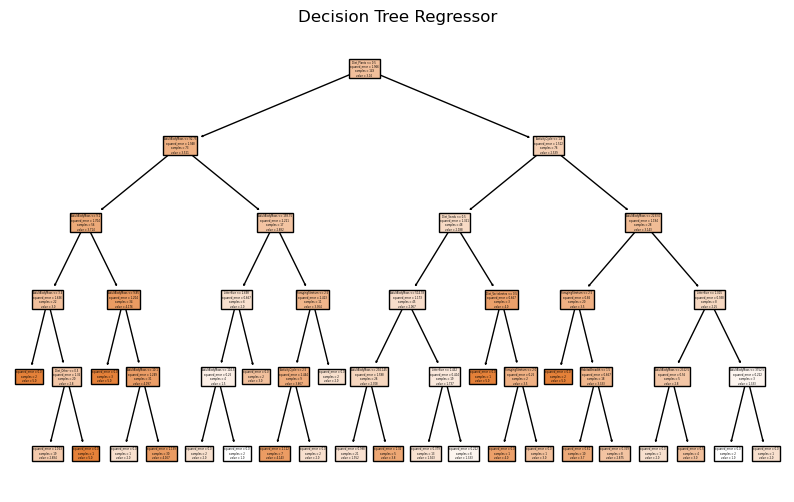

In [8]:
# Visualize the decision tree
plt.figure(figsize = (10, 6))
plot_tree(dt, feature_names=X.columns, filled = True)

# Add title
plt.title('Decision Tree Regressor')

# Save plot to view individual nodes
plt.savefig('decision_tree.svg', format = 'svg')

# Show Plot
plt.show()

Based on the way this tree looks, what would you guess the most important variable to be?

From the tree, the most important variable is the one the pops up most frequently at different nodes. From looking at our decision tree, we can see that AdultBodyMass is the most frequent, therefore it must be the most important variable in ourmodel.

### Step 5: Random forest with hyperparameter tuning
Now we'll use a more sophisticated ensemble approach where we optimize the values of key hyperparameters that govern tree growth.

- Define a parameter grid that includes the follow parameters and values:
  -  (sqrt(p), 6, and no set #) of the number of features to try at each split
  -  (50, 100, 200) total trees (learners)
  -  a maximum tree depth of (3,4,5,6,7)
  -  (2,5,10) minimum samples per split
  -  (1,2,4) minimum samples per leaf
  
- Use `GridSearchCV` with 5-fold cross-validation and mse (`neg_mean_squared_error`) to find the best combination of parameter values
- Train the best estimator.

In [9]:
# Define classifier
rf = RandomForestRegressor(random_state=808)

# Define a param grid with hyperparameters from above
param_grid = {
    'max_features': ['sqrt', 6, None],
    'n_estimators': [50, 100, 200],
    'max_depth': [3,4,5,6,7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Use GridSearchCV to find the best hyperparameters
gs = GridSearchCV(rf, param_grid = param_grid, cv = 5, n_jobs = -1)



### Step 6: Make predictions and evaluate random forest model
Use the optimized random forest model (`best_rf`) to predict the number of climates a species inhabits and analyze its performance.

- Use `best_rf` and `predict()` method on `X_test` to generate predictions
- Print the best set of parameter values using thte `best_params` method
- Compute and print the mse to evaluate model performance
- Extract feature importance from the trained random forest model
- Visualize feature importance using a bar plot

In [10]:
# Use best_rf and predict methond on X_test to get y_pred
best_rf = gs.fit(X_train, y_train)

# Make predictions
y_pred = best_rf.predict(X_test)

# Print the best hyperparameters
print(f"Best Hyperparameters: {best_rf.best_params_}")

# Compute MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.3f}")

# Extract feature importance
feature_importance = best_rf.best_estimator_.feature_importances_

# Create importance df
importance_df = pd.DataFrame(zip(X_test.columns, feature_importance), columns = ['Feature', 'Importance'])

# Sort by importance
importance_df = importance_df.sort_values(by = 'Importance', ascending = False)


Best Hyperparameters: {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Mean Squared Error: 1.445


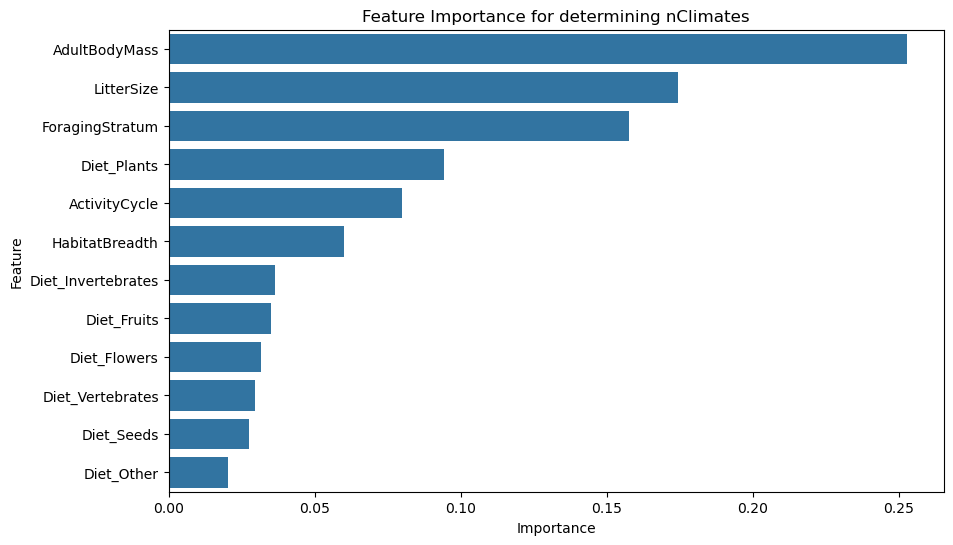

In [11]:



# Visualize feature importance
plt.figure(figsize = (10, 6))
sns.barplot(y = importance_df['Feature'], x = importance_df['Importance'])
#sns.barplot(x = feature_importance, y = X.columns)
plt.title('Feature Importance for determining nClimates')
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.show()



Which model had better accuracy, the single tree or the ensemble.  Interpret which traits have the most influence on species' climate adaptability.

The single decision tree had a higher mse of 1.99 compared to the random forest's mse of 1.445. Having a lower mse indicates that the model fits the data better and is able to make more accurate predictions. From our random forest model, AdultBodyMass, LitterSize, ActivityCycle and ForagingStratum play the most important role in determining species climate adaptability. 